In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import copy
from matplotlib import pyplot as plt
from matplotlib import pyplot

In [2]:
var_origin_0=pd.read_csv(r'C:\\Users\\JIBINBIN\\DA\\data\\bike\\time_based_out_sept.csv')
var_origin_1=pd.read_csv(r'C:\\Users\\JIBINBIN\\DA\\data\\bike\\time_based_out_sept_smooth.csv')
var_origin_2=pd.read_csv(r'C:\\Users\\JIBINBIN\\DA\\data\\bike\\time_based_out_sept_smooth_timeinfro.csv')
var_origin_0 = var_origin_0.drop(columns=['Unnamed: 0'])
var_origin_1 = var_origin_1.drop(columns=['Unnamed: 0'])
var_origin_2 = var_origin_2.drop(columns=['Unnamed: 0'])

In [3]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(var_origin_1)

var = torch.tensor(data=scaled).to(torch.float32)

In [4]:
def splitData(var,num_val,num_test):
    """
    拆分训练集、验证集、测试集
    输入：
    整体数据集、验证集个数、测试集个数
    输出：
    拆分后的数据集
    """
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

In [5]:
def create_train_sequence(input_data, tw, gap):
    """
    划分训练集序列和标签
    输入：
    训练集数据以及滑动窗口大小
    """
    train_seq_label=[]
    L = len(input_data)
    for i in range(L-tw*gap):
        train_seq = (input_data[i:i+tw*gap:gap])
        train_label = (input_data[i+tw*gap:i+tw*gap+1])
        train_seq_label.append((train_seq,train_label))
        
    return train_seq_label

In [6]:
def create_val_sequence(train_data,val_data,tw,gap):
    """
    划分验证集序列和标签，此前拆分数据集所得验证集为验证集标签
    输入：
    训练集数据、验证集数据以及滑动窗口
    """
    temp = torch.cat((train_data,val_data))  #先将训练集和测试集合并
    val_seq_label = []
    L = len(val_data)
    for i in range(L):
        val_seq = (temp[-(tw*gap+L)+i:-L+i:gap])
        val_label = (val_data[i:i+1])
        val_seq_label.append((val_seq,val_label))
        
    return val_seq_label


In [7]:
def create_test_sequence(train_data,val_data,test_data,tw,gap):
    """
    划分测试集序列和标签，此前拆分数据集所得验证集为验证集标签
    输入：
    训练集数据、验证集数据、测试集数据以及滑动窗口
    """
    temp = torch.cat((train_data,val_data))   #先将训练集和验证集合并
    temp = torch.cat((temp,test_data)) # 再将其与测试集合并
    test_seq_label = []
    L = len(test_data)
    for i in range(L):
        test_seq = (temp[-(tw*gap+L)+i:-L+i:gap])
        test_label = (test_data[i:i+1])
        test_seq_label.append((test_seq,test_label))
        
    return test_seq_label

In [8]:
"""
构建LSTM网络，网络拓扑结构为1-2-1-2
使用Xavier初始化
"""
from torch import nn
import torch.nn.functional as F
import torch.nn.init as init
import math
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_layer_size=2,output_size=1,num_layers=2):
        super().__init__()
        self.input_size=input_size
        self.hidden_layer_size=hidden_layer_size
        self.lstm=nn.LSTM(input_size,hidden_layer_size,num_layers)
        self.linear1=nn.Linear(hidden_layer_size,hidden_layer_size)
        self.linear2=nn.Linear(hidden_layer_size,output_size)
        self.hidden_cell=(torch.zeros(num_layers,1,self.hidden_layer_size),torch.zeros(num_layers,1,self.hidden_layer_size))
        init_rnn(self.lstm,'xavier')
        
    def forward(self,input_seq):
        hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size),torch.zeros(2, 1, model.hidden_layer_size)
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq),1,self.input_size), self.hidden_cell)
        out=self.linear1(lstm_out.view(len(input_seq), -1))
        out=torch.tanh(out)
        predictions = self.linear2(out)
        return predictions[-1]


def init_rnn(x, type='uniform'):
    """
    初始化网络权重
    网络采tanh激活函数，使用Xavier初始化
    """
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.normal_(getattr(x, w), .0, stdv)
                else:
                    raise ValueError


In [9]:
def train_model(train_seq_label,class_i, model,learning_r):
    """
    """
    loss_function=nn.MSELoss() # 损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_r) # 优化器，之前尝试过SGD效果较差且出现了预测试为一条直线的情况
    # 模型进入训练状态
    model.train()
    print('训练',class_i,'模型')
    epochs = 5
    Loss = nn.MSELoss(reduction='mean')
    for i in range(epochs):
        total_loss = 0
        y_pred=[]
        print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<{}>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(i+1))
        for seq,label in train_seq_label:
            optimizer.zero_grad()
            # 需要清空 LSTM 的隐状态
            # 将其从上个实例的历史中分离出来
            # 重新初始化隐藏层数据，避免受之前运行代码的干扰,如果不重新初始化，会有报错。
            model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size),torch.zeros(2, 1, model.hidden_layer_size))
            y_pred_i = model(seq[:,int(class_i[5:])])
            loss = Loss(y_pred_i[0],label[0,int(class_i[5:])])
            total_loss = total_loss + loss
            loss.backward() # 反向传播
            optimizer.step() # 更新梯度
            y_pred.append(y_pred_i[0])
        print("训练集MSE:{}".format(total_loss.data/len(train_seq_label)))


In [10]:
def val_model(val_seq_label,class_i, model):
    i=0
    loss= 0
    loss_function=nn.MSELoss() # 损失函数
    # 模型当前模式不进行网络更新
    model.eval()
    for seq,label in val_seq_label:
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
            y_pred_i = model(seq[:,int(class_i[5:])])
            loss_i = loss_function(y_pred_i[0],label[0,int(class_i[5:])])
            loss=loss+loss_i
        i=i+1
    
    return (loss.data/len(val_seq_label))

In [107]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


def test_model(test_seq_label,class_i, model):
    i=0
    y_pred = copy.deepcopy(test_data)
    # 模型当前模式不进行网络更新
    model.eval()
    for seq,label in test_seq_label:
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),torch.zeros(1, 1, model.hidden_layer_size))
            y_pred_i = model(seq[:,int(class_i[5:])])
            y_pred[i]=y_pred_i.data
        i=i+1

    actual_predictions = scaler.inverse_transform(np.array(y_pred))
    for i in range(len(actual_predictions[:,int(class_i[5:])])):
         actual_predictions[i,int(class_i[5:])] = math.floor(actual_predictions[i,int(class_i[5:])]+0.5)
    y_true = scaler.inverse_transform(test_data)
    

    plt.grid(True)
    
    for i in range(24):
        if(actual_predictions[i,int(class_i[5:])]<0):
            actual_predictions[i,int(class_i[5:])]=0
    
    plt.plot(np.arange(len(test_data)),y_true[:,int(class_i[5:])],label='real value')
    plt.plot(np.arange(len(test_data)),actual_predictions[:,int(class_i[5:])],label='prediction')

    plt.title('hours vs '+class_i)
    plt.ylabel(class_i)
    plt.xlabel('hour')

    plt.legend(loc='upper right',fontsize=8)
    
   
    return actual_predictions[:,int(class_i[5:])], y_true[:,int(class_i[5:])]
 

In [80]:
def pred_class_i(class_i,dw,learning_r,gap):
    model=LSTM() 
    train_data,val_data,test_data = splitData(var,48,24)
    train_seq_label = create_train_sequence(train_data, dw,gap)
    print('The total number of train windows is',len(train_seq_label))
    val_seq_label = create_val_sequence(train_data,val_data,dw,gap)
    print('The total number of validation windows is',len(val_seq_label))
    test_seq_label = create_test_sequence(train_data,val_data,test_data, dw,gap)
    print('The total number of validation windows is',len(test_seq_label))
    
    train_model(train_seq_label,class_i, model,learning_r)
    val_loss = val_model(val_seq_label,class_i, model)
    
    return val_loss

In [31]:
y_hat=[[]]*8
y_ture=[[]]*8

The total number of train windows is 720
The total number of validation windows is 48
The total number of validation windows is 24
训练 class0 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.029504094272851944
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.014331739395856857
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013639123179018497
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013543273322284222
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013533441349864006


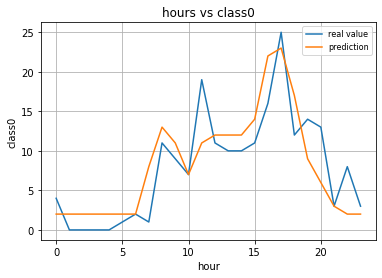

In [39]:
train_data,val_data,test_data = splitData(var,48,24)
train_seq_label = create_train_sequence(train_data, 240,24)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,240,24)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 240,24)
print('The total number of validation windows is',len(test_seq_label))

model0=LSTM() 
train_model(train_seq_label,'class0', model0,0.001)
y_hat_i,y_ture_i = test_model(test_seq_label,'class0', model0)
y_hat[0]=y_hat_i
y_ture[0]=y_ture_i

The total number of train windows is 4320
The total number of validation windows is 48
The total number of validation windows is 24
训练 class1 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.024545518681406975
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.019827950745821
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.01950506865978241
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.01943589560687542
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.019369062036275864


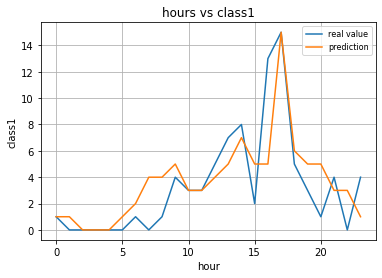

In [57]:
model1=LSTM() 

train_seq_label = create_train_sequence(train_data,90,24)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,90,24)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 90,24)
print('The total number of validation windows is',len(test_seq_label))

train_model(train_seq_label,'class1', model1,0.001)
y_hat_i,y_ture_i = test_model(test_seq_label,'class1', model1)
y_hat[1]=y_hat_i
y_ture[1]=y_ture_i

The total number of train windows is 4320
The total number of validation windows is 48
The total number of validation windows is 24
训练 class2 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.019926294684410095
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.018806103616952896
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.018827974796295166
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.018864808604121208
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.01888577826321125


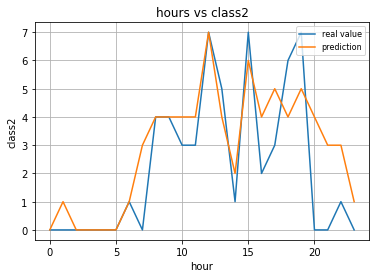

In [87]:
model2=LSTM()

train_seq_label = create_train_sequence(train_data, 90,24)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,90,24)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 90,24)
print('The total number of validation windows is',len(test_seq_label))

train_model(train_seq_label,'class2', model2,0.001)
y_hat_i,y_ture_i = test_model(test_seq_label,'class2', model2)
y_hat[2]=y_hat_i
y_ture[2]=y_ture_i

The total number of train windows is 2160
The total number of validation windows is 48
The total number of validation windows is 24
训练 class3 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.058346688747406006
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.0131484754383564
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.012977544218301773
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.012830703519284725
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.01270116213709116


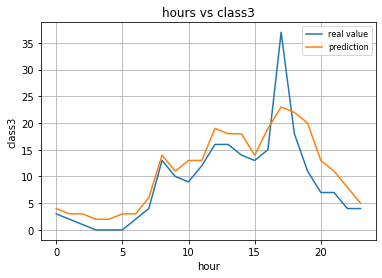

In [49]:
model3=LSTM() 

train_seq_label = create_train_sequence(train_data, 180,24)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,180,24)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 180,24)
print('The total number of validation windows is',len(test_seq_label))

train_model(train_seq_label,'class3', model3,0.001)
y_hat_i,y_ture_i = test_model(test_seq_label,'class3', model3)
y_hat[3]=y_hat_i
y_ture[3]=y_ture_i

The total number of train windows is 720
The total number of validation windows is 48
The total number of validation windows is 24
训练 class4 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.07330556213855743
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.01596115343272686
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013476424850523472
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013499435968697071
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013516679406166077


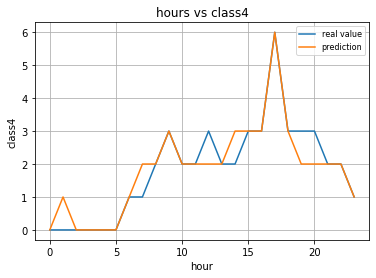

In [109]:
model4=LSTM() 

train_seq_label = create_train_sequence(train_data, 240,24)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,240,24)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 240,24)
print('The total number of validation windows is',len(test_seq_label))

train_model(train_seq_label,'class4', model4,0.003)

y_hat_i,y_ture_i = test_model(test_seq_label,'class4', model4)

y_hat[4]=y_hat_i
y_ture[4]=y_ture_i

The total number of train windows is 6240
The total number of validation windows is 48
The total number of validation windows is 24
训练 class5 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.02446146123111248
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.021323131397366524
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.02067386545240879
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.020458059385418892
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.020356489345431328


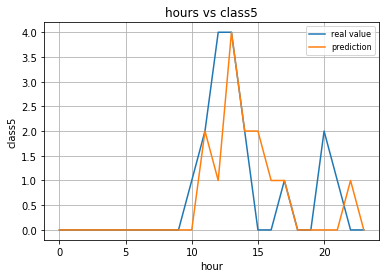

In [73]:
model5=LSTM() 

train_seq_label = create_train_sequence(train_data, 240,1)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,240,1)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 240,1)
print('The total number of validation windows is',len(test_seq_label))

train_model(train_seq_label,'class5', model5,0.001)
y_hat_i,y_ture_i = test_model(test_seq_label,'class5', model5)
y_hat[5]=y_hat_i
y_ture[5]=y_ture_i

The total number of train windows is 6450
The total number of validation windows is 48
The total number of validation windows is 24
训练 class6 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.022914081811904907
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.014475001953542233
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.014387698844075203
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013783998787403107
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.013901213183999062


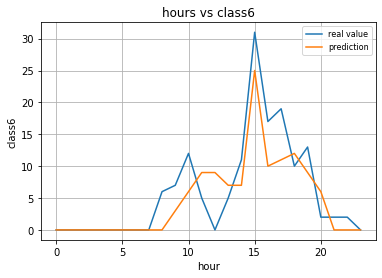

In [69]:
model6=LSTM()

train_seq_label = create_train_sequence(train_data, 30,1)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,30,1)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 30,1)
print('The total number of validation windows is',len(test_seq_label))

train_model(train_seq_label,'class6', model6,0.005)
y_hat_i,y_ture_i = test_model(test_seq_label,'class6', model6)
y_hat[6]=y_hat_i
y_ture[6]=y_ture_i

The total number of train windows is 6390
The total number of validation windows is 48
The total number of validation windows is 24
训练 class7 模型
<<<<<<<<<<<<<<<<<<<<<<<<<<<<1>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.04367522895336151
<<<<<<<<<<<<<<<<<<<<<<<<<<<<2>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.02206074632704258
<<<<<<<<<<<<<<<<<<<<<<<<<<<<3>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.02069973386824131
<<<<<<<<<<<<<<<<<<<<<<<<<<<<4>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.019750947132706642
<<<<<<<<<<<<<<<<<<<<<<<<<<<<5>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
训练集MSE:0.019440559670329094


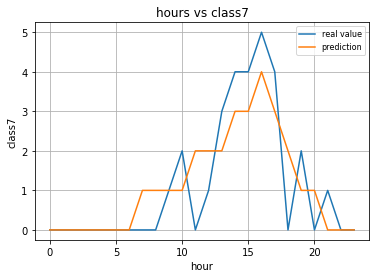

In [78]:
model7=LSTM() 

train_seq_label = create_train_sequence(train_data, 90,1)
print('The total number of train windows is',len(train_seq_label))
val_seq_label = create_val_sequence(train_data,val_data,90,1)
print('The total number of validation windows is',len(val_seq_label))
test_seq_label = create_test_sequence(train_data,val_data,test_data, 90,1)
print('The total number of validation windows is',len(test_seq_label))

train_model(train_seq_label,'class7', model7,0.001)
y_hat_i,y_ture_i = test_model(test_seq_label,'class7', model7)
y_hat[7]=y_hat_i
y_ture[7]=y_ture_i

In [110]:
from matplotlib import pyplot as plt
def show_graph(y_hat,y):
    clusters = [i for i in range(8)]
    plt.figure(figsize=(20,8))
    i=1
    for c in clusters:
        plt.subplot(2, 4, i)
        plt.plot(np.arange(24),y[i-1],label='real value')
        plt.plot(np.arange(24),y_hat[i-1],label='prediction')
        plt.title(c, y=0.5, loc='right')
        plt.legend(loc='upper right',fontsize=8)
        i += 1
    plt.show()
    

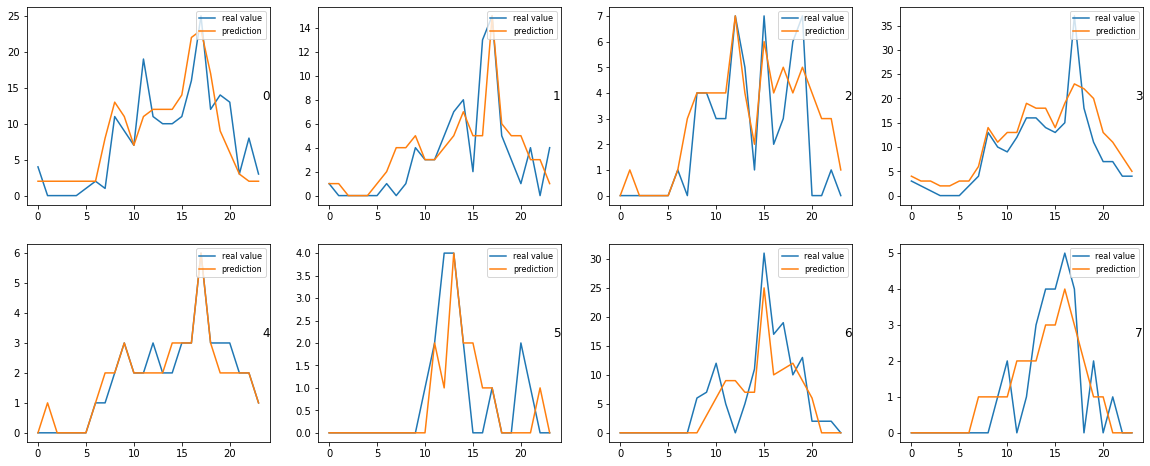

In [111]:
show_graph(y_hat,y_ture)

In [112]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("Test MSE:{:.8f}".format(mean_squared_error(y_hat, y_ture)))
print("Test MAE:{:.8f}".format(mean_absolute_error(y_hat, y_ture)))


Test MSE:7.52604144
Test MAE:1.65104164


In [ ]:
"""
调参:寻找最优学习率、滑窗
尝试运行调参，但多次运行时卡爆
"""
DW = [30,90,150,180,240]
Learning_R = [0.003,0.005,0.001,0.0001]
loss_list = [[] for i in range(4)]
i=0

for learning_r in Learning_R:
    for dw in DW:
        loss = pred_class_i('class0',dw,learning_r,1)
        loss_list[i].append(loss)
    i=i+1
    
plt.figure(figsize=(10,10))
for i in range(4):
    plt.plot(DW, loss_list[i],label='lr='+str(Learning_R[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('dw gap = 1')
plt.show()   